- Use all 2 years data
- Concatenate Description and Short Description
- Conact other columns 
- Run multiple algorithms

In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf

from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import datetime

## Used only once to subset the data

In [ ]:
cases = pd.read_csv('incident Jan2018-May2019 wDeptLoc Extract.csv', low_memory=False, parse_dates=['Opened At'],
                    usecols=['Requester Cost Center Descr', 
                             'Requester Location Desc', 
                             'Requester', 
                             'Assignment Group', 
                             'Contact Type', 
                             'Description', 
                             'Location', 
                             'Opened At',
                             'Short Description', 
                             'State', 
                             'U Functional Area',
                             'U Classification'
                             ])

In [ ]:
cases = cases[cases['State'].isin(['Closed', 'Closed (Purchase Required)', 'Closed (CR Implemented)','Resolved'])].copy()

In [ ]:
cases.columns

In [ ]:
cases.isnull().sum()

In [23]:
cases.to_csv('all data subset - closed.csv')

## Import saved subset and process further

In [5]:
cases = pd.read_csv('all data subset - closed.csv', low_memory=False, parse_dates=['Opened At'])
cases.drop('Unnamed: 0', axis=1, inplace=True)
cases.shape

(421957, 12)

In [3]:
cases.isnull().sum()

Requester Cost Center Descr    134017
Requester Location Desc        134017
Requester                        7905
Assignment Group                   10
Contact Type                       33
Description                     16449
Location                       131336
Opened At                           0
Short Description               91795
State                               0
U Classification                 4392
U Functional Area              170222
dtype: int64

In [6]:
#Delete cases where Assignment Group is NULL
cases = cases[-cases['Assignment Group'].isnull()].copy()
cases = cases[-cases['Requester'].isnull()].copy()
cases.shape

(414042, 12)

In [7]:
#Concat Description, Short Description, Requester,  'Requester Cost Center Descr', 'Requester Location Desc'
cases['fulltext'] = cases['Description'].astype(str) + ' ' + cases['Short Description'].astype(str) + ' ' + cases['Requester'].astype(str) + ' ' + cases['Requester Cost Center Descr'].astype(str) + ' ' + cases['Requester Location Desc'].astype(str)

In [8]:
cases.isnull().sum()

Requester Cost Center Descr    126102
Requester Location Desc        126102
Requester                           0
Assignment Group                    0
Contact Type                       31
Description                     15915
Location                       123490
Opened At                           0
Short Description               91785
State                               0
U Classification                 4373
U Functional Area              162388
fulltext                            0
dtype: int64

In [18]:
cases['cc'] = np.where(cases['Requester Cost Center Descr'].isnull(), cases['Requester'], cases['Requester Cost Center Descr'])

In [19]:
cases.isnull().sum()

Requester Cost Center Descr    126102
Requester Location Desc        126102
Requester                           0
Assignment Group                    0
Contact Type                       31
Description                     15915
Location                       123490
Opened At                           0
Short Description               91785
State                               0
U Classification                 4373
U Functional Area              162388
fulltext                            0
cc                                  0
dtype: int64

In [21]:
#save intermediary dataset
cases.to_csv('all data subset - closed and fulltext.csv')

In [11]:
cases.shape

(421947, 13)

## Prep tfidf

In [7]:
cases = pd.read_csv('all data subset - closed and fulltext.csv', low_memory=False,parse_dates=['Opened At'])
cases.shape

(414042, 15)

In [8]:
len(cases['Assignment Group'].unique())

296

## Import finance cases and list AGs

In [9]:
#import data (do only once)
fin_cases = pd.read_excel('incident V2 - Enriched.xlsx')


In [12]:
fin_cases.shape

(34564, 44)

In [15]:
fin_cases.columns

Index(['number', 'state', 'u_region', 'u_business_priority',
       'u_classification', 'urgency', 'assigned_to', 'opened_at',
       'u_closure_category', 'u_requester', 'u_requested_by_date',
       'short_description', 'description', 'cmdb_ci', 'u_sla_breached',
       'u_sla_breached_reason', 'sla_due', 'sys_updated_on', 'comments',
       'u_bsa_comments', 'u_business_comments', 'u_developer_comments',
       'u_tech_lead_comments', 'work_notes', 'ag', 'u_comments_and_work_notes',
       'u_problem_code', 'u_problem_description',
       'u_previous_assignment_groups', 'Requester Person ID',
       'Requester User Id', 'Requester Full Name', 'Requester Grade',
       'Requester Supervisor', 'Requester Cost Center Descr',
       'Requester Location Desc', 'Assigned To Person ID',
       'Assigned To User Id', 'Assigned To Full Name', 'Assigned To Grade',
       'Assigned To Supervisor', 'Assigned To Cost Center Descr',
       'Assigned To Location Desc', 'cln_desc1'],
      dtype='o

In [10]:
# Use only closed cases
fin_cases = fin_cases[fin_cases['state'].isin(['Closed', 'Closed (CR Implemented)', 'Closed (Purchase Required)', 'Resolved'])].copy()

In [19]:
fin_cases['fulltext'] = fin_cases['description'].astype(str) + ' ' + fin_cases['short_description'].astype(str) + ' ' + fin_cases['u_requester'].astype(str) + ' ' + fin_cases['Requester Cost Center Descr'].astype(str) + ' ' + fin_cases['Requester Location Desc'].astype(str)

In [11]:
fin_cases = fin_cases[fin_cases['opened_at'] > '12/31/2017']

In [12]:
fin_cases.shape

(5834, 44)

In [13]:
fin_ags = fin_cases['ag'].unique()

In [39]:
#Remove stop words in English when creating tf idf vector 
fin_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_fit = fin_vectorizer.fit(fin_cases['fulltext'].values)
fin_tfidf = fin_vectorizer.transform(fin_cases['fulltext'].values)

In [40]:
fin_tfidf.shape

(5834, 59256)

In [41]:
mf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
mf.fit(fin_tfidf, fin_cases['ag'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
len(mf.feature_importances_)

59256

In [42]:
#Use the feature importance to find the most important finance words
feature_importance = pd.DataFrame({'Feature' : fin_vectorizer.get_feature_names(), 'Importance' : mf.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
#Consider words with importance > than 0.0001 as important and remove them from stop words
fin_words = feature_importance[feature_importance['Importance'] >= 0.0001]['Feature']


In [44]:
len(fin_words)

1578

## Remove Fin words from stop words

In [63]:
#Get most important words from tf idf
#Remove stop words in English when creating tf idf vector and create train set
vectorizer = TfidfVectorizer(stop_words='english').fit(cases['fulltext'].values)
tfidf = vectorizer.transform(cases['fulltext'].values)
print(tfidf.shape)


(414042, 828568)


In [31]:
#Run RF on tf idf and fit and find important features
m = RandomForestClassifier(n_estimators=100, n_jobs=-1)
m.fit(tfidf, cases['Assignment Group'])



In [64]:
#Use the feature importance to find the most important words
feature_importance = pd.DataFrame({'Feature' : vectorizer.get_feature_names(), 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.shape

(828568, 2)

In [65]:
# Create customer stop words
#Consider words with importance less than 0.00005 as unimportant and remove them from tf idf
words_to_remove = feature_importance[feature_importance['Importance'] < 0.00005]['Feature']
len(words_to_remove)

826264

In [66]:
len(fin_words)

1578

In [60]:
type(fin_words)

pandas.core.series.Series

In [67]:
#Remove important fin words from stop words so that they are incuded in the tfidf
words_to_remove_sub = list(set(words_to_remove).difference(set(fin_words)))
len(words_to_remove_sub)

825731

In [68]:
words_to_remove_sub = [x for x in list(words_to_remove) if x not in list(fin_words)]
len(words_to_remove_sub)

825731

In [69]:

#Add words to remove to stop words and create new tf idf
my_stop_words = text.ENGLISH_STOP_WORDS.union(words_to_remove_sub)
len(my_stop_words)

826049

In [70]:
#Get most important words from tf idf
#Remove stop words in English when creating tf idf vector and create train set
vectorizer = TfidfVectorizer(stop_words=my_stop_words).fit(cases['fulltext'].values)
tfidf = vectorizer.transform(cases['fulltext'].values)
print(tfidf.shape)


(414042, 2837)


## Prep columns

In [71]:
cases.columns

Index(['Unnamed: 0', 'Requester Cost Center Descr', 'Requester Location Desc',
       'Requester', 'Assignment Group', 'Contact Type', 'Description',
       'Location', 'Opened At', 'Short Description', 'State',
       'U Classification', 'U Functional Area', 'fulltext', 'cc'],
      dtype='object')

In [73]:
#Choose columns needed
df_feature = cases[['cc', 'Requester Location Desc', 'Contact Type', 'Location', 'Opened At', 'U Classification', 'U Functional Area', 'Assignment Group']].copy() 

In [75]:
df_feature_ohe = pd.get_dummies(df_feature,columns=['cc', 'Requester Location Desc', 'Contact Type', 'Location', 'U Classification', 'U Functional Area'])

In [76]:
df_feature_ohe.shape

(414042, 1047)

In [77]:
#Concatenate tfidf and feature set to create full set
tfidf_df = pd.DataFrame(tfidf.todense())
tfidf_df.reset_index(drop=True, inplace=True)
df_feature_ohe.reset_index(drop=True, inplace=True)
cases_full = pd.concat([tfidf_df, df_feature_ohe], axis=1)

In [78]:
cases_full.shape

(414042, 3884)

In [81]:
#Save intermediate file 
cases_full.to_csv('all data - tfidf and ohe without requester add fin ags.csv')

## Import final dataset (start here)

In [2]:
#Import file
cases_full = pd.read_csv('all data - tfidf and ohe without requester.csv', parse_dates=['Opened At'] )

In [2]:
#Import file
cases_full = pd.read_csv('all data - tfidf and ohe without requester add fin ags.csv', parse_dates=['Opened At'] )

In [7]:
cases_full = df_feature_ohe.copy()

In [3]:
#Split into train and test
train = cases_full[cases_full['Opened At'] < '04/01/2019'].copy()
test = cases_full.drop(index=train.index, axis=1).copy()
train.shape, test.shape

((360937, 3885), (53105, 3885))

In [4]:
train.drop('Opened At', axis=1, inplace=True)
test.drop('Opened At', axis=1, inplace=True)


In [5]:
#Run RF on tf idf and fit
iters = 100
m = RandomForestClassifier(n_estimators=iters, n_jobs=-1).fit(train.drop('Assignment Group', axis=1), train['Assignment Group'])

In [7]:
#Do predictions
pred_label = m.predict(test.drop('Assignment Group', axis=1))
pred_probs = m.predict_proba(test.drop('Assignment Group', axis=1))
pred_df = pd.DataFrame(pred_probs)
cols = pred_df.columns 

pred_df['first_max_label'] = pred_label
pred_df['first_max_probs'] = pred_probs.max(axis=1)

'''second_label = []
for i in range(0,len(pred_probs)):
    second_label.append(np.argsort(-pred_probs)[i][1])
pred_df['second_max_label'] = second_label

probs_list = pred_probs.copy()
second_probs = []
for j in range(0,len(probs_list)):
    probs_list[j].sort()
    second_probs.append(probs_list[j][-2])
pred_df['second_max_probs'] = second_probs
pred_df['actual'] = test['Assignment Group'].values
pred_df['model'] = 'rf blend tfidf features'
'''

#pred_df = pred_df[['model', 'actual', 'first_max_label', 'first_max_probs', 'second_max_label','second_max_probs'] + list(cols)]

"second_label = []\nfor i in range(0,len(pred_probs)):\n    second_label.append(np.argsort(-pred_probs)[i][1])\npred_df['second_max_label'] = second_label\n\nprobs_list = pred_probs.copy()\nsecond_probs = []\nfor j in range(0,len(probs_list)):\n    probs_list[j].sort()\n    second_probs.append(probs_list[j][-2])\npred_df['second_max_probs'] = second_probs\npred_df['actual'] = test['Assignment Group'].values\npred_df['model'] = 'rf blend tfidf features'\n"

In [34]:
#Calculate accuracy
no_of_ags = 'all'
Accuracy = accuracy_score(test['Assignment Group'], pred_label)
model = 'RandomForestClassifier'
date = datetime.datetime.now()
#model_params.update({'Accuracy': accuracy_score(test['Assignment Group'], pred_label})
model_params = dict(((k, eval(k)) for k in ('Accuracy', 'no_of_ags', 'model', 'date', 'iters')))
model_params_df = pd.DataFrame.from_dict(model_params, orient='index').T
model_params_df['model'] = 'rf blend tfidf features'

#Use the feature importance to find the most important words
feature_importance = pd.DataFrame({'Feature' : train.drop('Assignment Group', axis=1).columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance['model'] = 'rf blend tfidf features'

#Confusion matrix analysis
cm_df = pd.DataFrame(confusion_matrix(test['Assignment Group'], pred_label)) 
labels = np.sort(list(set().union(pred_label, test['Assignment Group'])))
cm_df.columns = labels
cm_df['ag_name'] = labels
cm_df.set_index('ag_name', inplace=True)

'''#Create flat confusion matrix
a = []
p = []
c = []
t = []
for i in  labels: #np.sort(list(set().union(pred_label, test['Assignment Group']))):
    for j in labels: #np.sort(list(set().union(pred_label, test['Assignment Group']))):
        a.append(i)
        p.append(j)
        c.append(cm_df[i][j])
        t.append(cm_df[i].sum())
        
confusion = pd.DataFrame({'actual': a, 'predicted':p, 'count': c, 'total_actual':t})
                     
confusion['model'] = 'rf blend tfidf features' '''

confusion = cm_df.unstack().reset_index(name='count')
confusion.columns = ['predicted', 'actual', 'count']
confusion['model'] = 'rf blend tfidf features'

with pd.ExcelWriter('rf blend tfidf features add fin ags.xlsx') as writer:  # doctest: +SKIP
    pred_df.to_excel(writer, sheet_name='probability')
    feature_importance.head(30).to_excel(writer, sheet_name='feature importance')
    model_params_df.to_excel(writer, sheet_name='parameters')
    confusion.to_excel(writer, sheet_name='confusion matrix')

In [16]:
fin_confusion = confusion[confusion['actual'].isin(fin_ags)]

In [19]:
fin_confusion.to_csv('fin confusion.csv')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [22]:
cm_df.to_csv('cm df.csv')

Confusion matrix, without normalization
[[  5   0   0 ...   0   0   0]
 [  0 253   0 ...   0   0   0]
 [  0   0 223 ...   0   0   0]
 ...
 [  0   0   0 ...  11   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   9]]


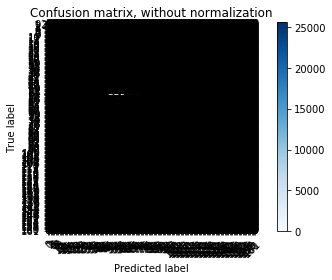

In [26]:
plot_confusion_matrix(test['Assignment Group'], pred_label, classes= range(0,290),title='Confusion matrix, without normalization')

In [33]:
cm_flat.to_csv('cm flat.csv')